In [26]:
import numpy as np
import pandas as pd
import os
from dask import dataframe as dd
import gc

os.chdir('/Users/wang/Desktop/7. ml_project/20230302_ml_paper')

## Prepare firm charicteriestic data


In [4]:
# load data from open source asset pricing
firm = dd.read_csv('data/raw_data/signed_predictors_dl_wide.csv', low_memory=False, assume_missing=True)

# choose data from date since 1957
firm_1957 = firm[firm['yyyymm'] > 195612]
firm_1957['yyyymm'] = dd.to_datetime(firm_1957['yyyymm'], format='%Y%m', errors='coerce').dropna()
firm_1957['year_month'] = firm_1957['yyyymm'].dt.to_period('M')

# load monthly price data from CRSP
month_price = pd.read_csv('data/raw_data/monthly_stock_CRSP_new.csv')

# get date
month_price['date'] = pd.to_datetime(month_price['date'])
month_price['year_month'] = month_price['date'].dt.to_period('M')

# create variables: 'PRC', 'Size', and 'STreversal'
month_price['PRC'] = month_price['PRC'].abs()
month_price['Size'] = month_price['SHROUT'] * month_price['PRC']

# replace missing return with nan
month_price['RETX'] = month_price['RETX'].replace({'C': np.nan, 'B': np.nan})
month_price['STreversal'] = month_price['RETX'].astype(float)

# select variables 
month_price = month_price[['PERMNO', 'year_month', 'PRC', 'STreversal', 'Size']]

# drop nas
month_price.dropna(inplace=True)

# merge with firm data
merge_data = dd.merge(firm_1957, month_price, how='left', left_on=['permno', 'year_month'], right_on=['PERMNO', 'year_month'])

# choose cols
cols = ['permno', 'year_month', 'InvestPPEInv', 'ShareIss1Y', 'ShareRepurchase', 'DelCOA', 'dNoa', 'GrLTNOA', 'IntMom', 'LRreversal', 'Mom12m', 'Mom6m', 'MRreversal', 'ResidualMomentum', 'STreversal', 'AM', 'BMdec', 'ChEQ', 'AssetGrowth', 'ChNWC', 'DelEqu', 'NOA', 'Size', 'SP', 'AbnormalAccruals', 'Accruals', 'PctAcc', 'OPLeverage', 'BookLeverage', 'CF', 'cfp', 'DelCOL', 'DelFINL', 'IdioRisk', 'IdioVol3F', 'Leverage', 'Beta', 'BetaFP', 'BidAskSpread', 'DolVol', 'Illiquidity', 'PRC', 'VolMkt', 'VolSD', 'High52', 'MaxRet', 'CashProd', 'GP', 'roaq', 'RoE', 'DelLTI']

# subset 
merge_data_sub = merge_data[cols].copy()
drop_na = merge_data_sub.dropna().copy()

# convert to pandas dataframe
firm_data = drop_na.compute()

# collect memory
del[firm, firm_1957, month_price, merge_data, merge_data_sub, drop_na]
gc.collect()

# number of observations
assert firm_data.shape == (1396241, 51)

# number of companies in total
firm_data.permno.nunique() == 11830

True

## add real economy activities data

In [6]:
# merge with cfnai
cfnai = pd.read_excel('data/raw_data/cfnai-data-series-xlsx.xlsx')
cfnai['year_month'] = pd.PeriodIndex(cfnai['Date'], freq='M')
df = pd.merge(firm_data, cfnai, how='left', on='year_month')

df.dropna(inplace=True)

## add investors semtiment data

In [7]:
sent = pd.read_excel('data/raw_data/Investor_Sentiment_Data_20220821_POST.xlsx', sheet_name='DATA')
sent['year_month'] = pd.PeriodIndex(sent['yearmo'], freq='M')
sent = sent[['year_month', 'SENT', 'pdnd', 'ripo', 'nipo', 'cefd', 's']]
sent = sent.fillna(sent.median())

# add sentiment data
df = pd.merge(df, sent, on='year_month', how='left')

## add financial market data

In [36]:
# imort very large daily stock return dataset
stock = dd.read_csv('data/raw_data/daily_stock_CRSP.csv', low_memory=False, assume_missing=True)
# choose daily sp500 return
stock = stock.groupby('date').sprtrn.last().compute()
stock = stock.to_frame().copy()
stock['date'] = stock.index
stock.reset_index(inplace=True, drop=True)

# choose time period
stock = stock[(stock.date > '1971/11/31') & (stock.date < '2022/01/01')]
stock.reset_index(inplace=True, drop=True)

# get year_month
stock['year_month'] = pd.to_datetime(stock.date).dt.strftime('%Y-%m')

# compute monthly sp500 return variance based on daily return data
sp500 = pd.DataFrame(stock.groupby('year_month').sprtrn.var()*100)

# rename cols
sp500.reset_index(inplace=True)
sp500.columns = ['year_month', 'sp500var']

# load sp500 data from Robert Shiller’s website
sp500_data = pd.read_csv('data/raw_data/sp500_data.csv')

# merge two datasets
sp500 = sp500_data.merge(sp500, on='year_month', how='inner')

In [9]:
# convert datatype merge with df
sp500['year_month'] = pd.PeriodIndex(sp500['year_month'], freq='M')
df = df.merge(sp500, on='year_month', how='left')

## add Fama-French 5 Factors Data

In [10]:
ff = pd.read_csv('data/raw_data/F-F_Research_Data_5_Factors_2x3.csv')
ff['year_month'] = pd.PeriodIndex(ff.date, freq='M')
df = pd.merge(df, ff, how='left', on='year_month')

# collect some memory
del[firm_data, cfnai, sent, ff]
gc.collect()

21

## Prepare abnormal stock return and excess stock return 

In [11]:
# import stock monthly data and fama-french 5 factors data
stock = pd.read_csv('data/raw_data/monthly_stock_CRSP_new.csv')
ff = pd.read_csv('data/raw_data/F-F_Research_Data_5_Factors_2x3.csv')

stock['RETX'] = stock['RETX'].replace({'C': np.nan, 'B': np.nan})
stock['RETX'] = stock['RETX'].astype(float)

stock['date'] = pd.to_datetime(stock.date)
stock['year_month'] = stock['date'].dt.to_period('M')
ff['year_month'] = pd.PeriodIndex(ff.date, freq='M')

# merge two datasets
merged = pd.merge(stock, ff, how='left', on='year_month')
# stock excess return
merged['ex_return'] = merged['RETX']*100 - merged['RF']

# sellect variables
data = merged[['PERMNO', 'year_month', 'ex_return', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
data = data.dropna()

# clear memory
del[stock, ff, merged]
gc.collect()

# require a stock at least have 36 month return data
data['number'] = data.groupby('PERMNO')['PERMNO'].transform("count")
data = data[data['number'] > 35]

data = data.sort_values(['PERMNO', 'year_month'])

In [13]:
# abnormal return with CAPM, ff3, and ff5 models
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

# regression on Mkt-Rf for 36-month rolling widow (CAPM model)
data[['capm_a', 'capm_b']] = data.groupby("PERMNO", group_keys=False).apply(lambda x: RollingOLS(endog=x['ex_return'], exog=sm.add_constant(x[['Mkt-RF']]), window=36).fit().params).copy()

# regression on ff 3 factors for 36-month rolling window
data[['ff3_a', 'ff3_b1', 'ff3_b2', 'ff3_b3']] = data.groupby("PERMNO", group_keys=False).apply(lambda x: RollingOLS(endog=x['ex_return'], exog=sm.add_constant(x[['Mkt-RF', 'SMB', 'HML']]), window=36).fit().params).copy()

# regression on ff 5 factors for 36-month rollilng window
data[['ff5_a', 'ff5_b1', 'ff5_b2', 'ff5_b3', 'ff5_b4', 'ff5_b5']] = data.groupby("PERMNO", group_keys=False).apply(lambda x: RollingOLS(endog=x['ex_return'], exog=sm.add_constant(x[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]), window=36).fit().params).copy()

In [14]:
# abnormal return for the 37th month
data[['ex_return', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']] =  data.groupby('PERMNO')[['ex_return', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].shift(-1)
data.dropna(inplace=True)

# abnormal return of CAPM model
data['ab_capm'] = data['ex_return'] - (data['Mkt-RF']*data['capm_b'])

# abnormal return of ff 3 factors model
data['ab_ff3'] = data['ex_return'] - (data['Mkt-RF']*data['ff3_b1'] + data['SMB']*data['ff3_b2'] + data['HML']*data['ff3_b3'])

# abnormal return of ff 5 factors model
data['ab_ff5'] = data['ex_return'] - (data['Mkt-RF']*data['ff5_b1'] + data['SMB']*data['ff5_b2'] + data['HML']*data['ff5_b3'] + data['RMW']*data['ff5_b4'] + data['CMA']*data['ff5_b5'])

data = data[['PERMNO', 'year_month', 'ab_capm', 'ab_ff3', 'ab_ff5', 'ex_return']]

# merge with abnormal return data
dataset = pd.merge(data, df, how='inner', left_on=['PERMNO', 'year_month'], right_on=['permno', 'year_month'])

## Save Prepared Dataset

In [15]:
a = dataset['ab_capm'].mean()
print('The monthly mean stock capm abnormal return is %s' % a)
b = dataset['ab_capm'].std()
print('The monthly standard deviation of stock capm abnormal return is %s' % b)
a = dataset['ab_ff3'].mean()
print('The monthly mean stock ff3 abnormal return is %s' % a)
b = dataset['ab_ff3'].std()
print('The monthly standard deviation of stock ff3 abnormal return is %s' % b)
a = dataset['ab_ff5'].mean()
print('The monthly mean stock ff5 abnormal return is %s' % a)
b = dataset['ab_ff5'].std()
print('The monthly standard deviation of stock ff5 abnormal return is %s' % b)
a = dataset['ex_return'].mean()
print('The monthly mean stock excess return is %s' % a)
b = dataset['ex_return'].std()
print('The monthly standard deviation of stock excess return is %s' % b)

The monthly mean stock capm abnormal return is 0.10153990384187554
The monthly standard deviation of stock capm abnormal return is 16.291366796428687
The monthly mean stock ff3 abnormal return is -0.00010050359471907867
The monthly standard deviation of stock ff3 abnormal return is 16.54170487952805
The monthly mean stock ff5 abnormal return is 0.08599306755994382
The monthly standard deviation of stock ff5 abnormal return is 17.26117328027567
The monthly mean stock excess return is 0.8966402161900004
The monthly standard deviation of stock excess return is 16.955298349438625


In [243]:
dataset.to_pickle('data/dataset.pkl')

## Summary statistics

In [244]:
dataset[['ab_capm', 'ab_ff3', 'ab_ff5', 'ex_return']].describe()

,ab_capm,ab_ff3,ab_ff5,ex_return
count,1.397937e+06,1.397937e+06,1.397937e+06,1.397937e+06
mean,1.015399e-01,-1.005036e-04,8.599307e-02,8.966402e-01
std,1.629137e+01,1.654170e+01,1.726117e+01,1.695530e+01
min,-2.305630e+02,-2.747691e+02,-4.294537e+02,-9.847760e+01
25%,-7.001071e+00,-7.179707e+00,-7.391555e+00,-6.721100e+00
50%,-7.368505e-01,-7.572404e-01,-6.698236e-01,-2.113000e-01
75%,5.663393e+00,5.775803e+00,6.229083e+00,6.927000e+00
max,1.891982e+03,1.892810e+03,1.904276e+03,1.899750e+03


## Plot stock returns

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=1.3, style='white')

In [13]:
dataset = pd.read_pickle('data/dataset.pkl')

In [14]:
dat = dataset.groupby('year_month').agg(capm_mean=pd.NamedAgg(column='ab_capm', aggfunc='mean'),
                                     ff3_mean=pd.NamedAgg(column='ab_ff3', aggfunc='mean'),
                                     ff5_mean=pd.NamedAgg(column='ab_ff5', aggfunc='mean'),
                                     ex_mean=pd.NamedAgg(column='ex_return', aggfunc='mean'),
                                     capm_std=pd.NamedAgg(column='ab_capm', aggfunc='std'),
                                     ff3_std=pd.NamedAgg(column='ab_ff3', aggfunc='std'),
                                     ff5_std=pd.NamedAgg(column='ab_ff5', aggfunc='std'),
                                     ex_std=pd.NamedAgg(column='ex_return', aggfunc='std'))

# convert back to fraction from pecentage 
dat = dat.divide(100)
# convert data type of "year_month" for plot
dat['year_month'] = dat.index.astype(str)
dat['year_month'] = pd.to_datetime(dat['year_month'], format='%Y-%m') 
# create column names
cols = ['CAPM abnormal return', 'FF3 abnormal return', 'FF5 abnormal return', 'Excess return', 'year_month']
# compute cumulative returns
dat[['capm_mean', 'ff3_mean', 'ff5_mean', 'ex_mean']] = dat[['capm_mean', 'ff3_mean', 'ff5_mean', 'ex_mean']].cumsum()

# prepare for plot
tidy1 = dat[['capm_mean', 'ff3_mean', 'ff5_mean', 'ex_mean', 'year_month']]
tidy1.columns = cols
tidy1 = tidy1.melt(id_vars='year_month').rename(columns=str.title)
tidy2 = dat[['capm_std', 'ff3_std', 'ff5_std', 'ex_std', 'year_month']]
tidy2.columns = cols
tidy2 = tidy2.melt(id_vars='year_month').rename(columns=str.title)

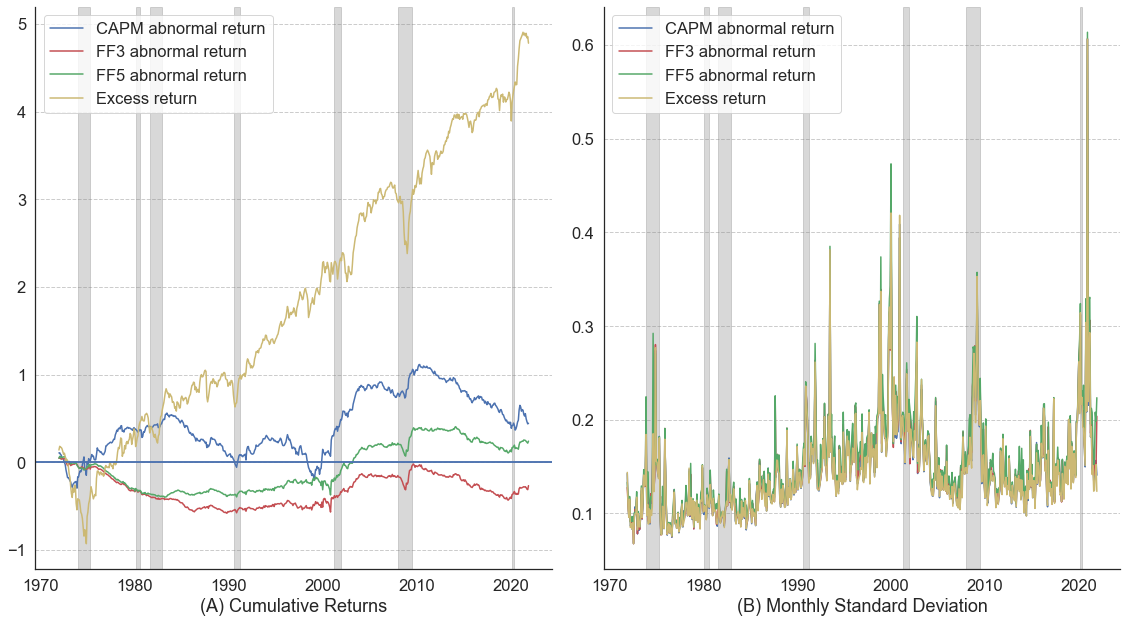

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=1.5, style='white')

fig, ax = plt.subplots(1,2,figsize=(16,9))

# load nber recession data
nber = pd.read_excel('data/raw_data/NBER_recession.xlsx')
nber['Peak'] = pd.PeriodIndex(nber.Peak, freq='M')
nber = nber[nber.Peak > '1971-11']
nber['Trough'] = pd.PeriodIndex(nber[' Trough'], freq='M')

colors = ['b', 'r', 'g', 'y']
sns.lineplot(data=tidy1, x='Year_Month', y='Value', hue='Variable', palette=colors, ax=ax[0])
sns.lineplot(data=tidy2, x='Year_Month', y='Value', hue='Variable', palette=colors, ax=ax[1])

# shade recession area
for a in range(0,2):
  for i in range(1, 8):
    ax[a].axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.3, color='grey')
# hide legend title
  handles, labels = ax[a].get_legend_handles_labels()
  ax[a].legend(handles=handles[0:], labels=labels[0:], loc='upper left')
  ax[0].axhline() 
  ax[a].grid(axis='y', linestyle='--')
  
ax[0].set(xlabel='(A) Cumulative Returns', ylabel='')
ax[1].set(xlabel='(B) Monthly Standard Deviation', ylabel='')

# remove frame
sns.despine(fig)
# outpot plot
plt.tight_layout()  # Adjust subplot layout for better spacing

# Specify high resolution (dpi) when saving the figure using Matplotlib's savefig
plt.savefig('graphics/mean_std.png', dpi=300)

## Plot Macro Data

In [27]:
cfnai = pd.read_excel('data/raw_data/cfnai-data-series-xlsx.xlsx')
cfnai = cfnai[(cfnai.Date > '1971-11-30') & (cfnai.Date < '2022-01-01')]

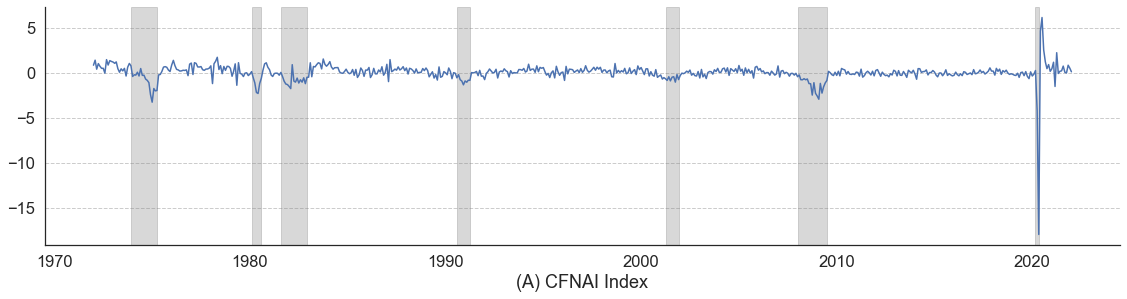

In [28]:
# plot CFNAI index with NBER suggested recessions
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=1.5, style='white')

# load nber recession data
# load nber recession data
nber = pd.read_excel('data/raw_data/NBER_recession.xlsx')
nber['Peak'] = pd.PeriodIndex(nber.Peak, freq='M')
nber = nber[nber.Peak > '1971-11']
nber['Trough'] = pd.PeriodIndex(nber[' Trough'], freq='M')

fig, ax = plt.subplots(1,1,figsize=(16,4.5))
sns.lineplot(data=cfnai, x='Date', y='CFNAI')
plt.xlabel('(A) CFNAI Index')
plt.ylabel('')
ax.grid(axis='y', linestyle='--')
# shade recession area
for i in range(1, 8):
 ax.axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.3, color='grey')

# remove frame
sns.despine(fig)

# outpot plot
plt.tight_layout()  # Adjust subplot layout for better spacing

# Specify high resolution (dpi) when saving the figure using Matplotlib's savefig
plt.savefig('graphics/economic_activities_cfnai.png', dpi=300)

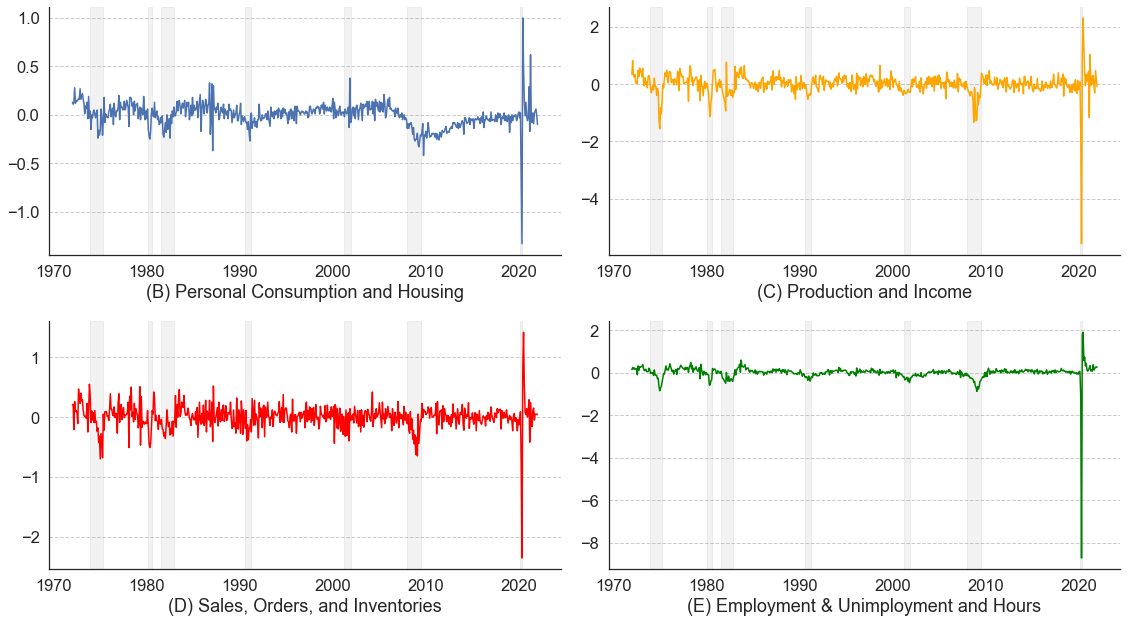

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=1.5, style='white')

fig, ax = plt.subplots(2,2, figsize=(16,9))
sns.lineplot(data=cfnai, x='Date', y='C_H', ax=ax[0][0])
sns.lineplot(data=cfnai, x='Date', y='P_I', ax=ax[0][1], color='orange')
sns.lineplot(data=cfnai, x='Date', y='SO_I', ax=ax[1][0], color='red')
sns.lineplot(data=cfnai, x='Date', y='EU_H', ax=ax[1][1], color='green')

ax[0][0].set(xlabel='(B) Personal Consumption and Housing', ylabel=None)
ax[0][1].set(xlabel='(C) Production and Income', ylabel=None)
ax[1][0].set(xlabel='(D) Sales, Orders, and Inventories', ylabel=None)
ax[1][1].set(xlabel='(E) Employment & Unimployment and Hours', ylabel=None)

# shade recession area
for i in range(1, 8):
 ax[0][0].axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.1, color='grey')
 ax[0][1].axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.1, color='grey')
 ax[1][0].axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.1, color='grey')
 ax[1][1].axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.1, color='grey')
 
for a in range(0,2):
  for b in range(0,2):
    ax[a][b].grid(axis='y', linestyle='--')

# remove frame
sns.despine(fig)

# outpot plot
plt.tight_layout()  # Adjust subplot layout for better spacing

# Specify high resolution (dpi) when saving the figure using Matplotlib's savefig
plt.savefig('graphics/economic_activities_others.png', dpi=300)

## Plot Sentiment Data

In [30]:
sent = pd.read_excel('data/raw_data/Investor_Sentiment_Data_20220821_POST.xlsx', sheet_name='DATA')
sent['year_month'] = pd.to_datetime(sent['yearmo'], format='%Y%m')
sent = sent[(sent['year_month']>"1971-11-30") & (sent['year_month']<"2022-01-01")]
sent = sent[['year_month', 'SENT', 'pdnd', 'ripo', 'nipo', 'cefd', 's']]
sent = sent.fillna(sent.median(numeric_only=True))

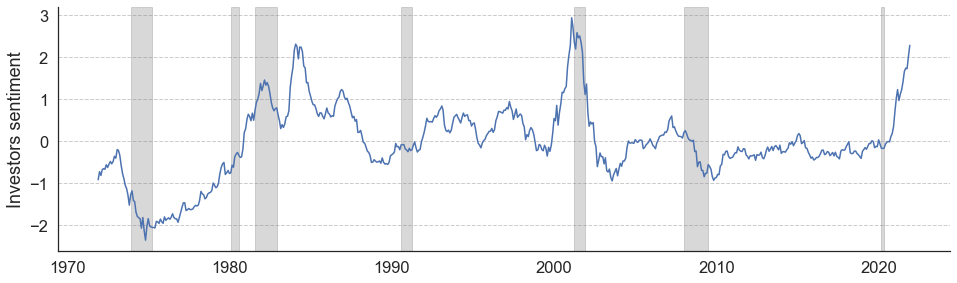

In [31]:
# plot CFNAI index with NBER suggested recessions
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=1.5, style='white')

# load nber recession data
# load nber recession data
nber = pd.read_excel('data/raw_data/NBER_recession.xlsx')
nber['Peak'] = pd.PeriodIndex(nber.Peak, freq='M')
nber = nber[nber.Peak > '1971-11']
nber['Trough'] = pd.PeriodIndex(nber[' Trough'], freq='M')

fig, ax = plt.subplots(1,1,figsize=(16,4.5))
sns.lineplot(data=sent, x='year_month', y='SENT')
plt.xlabel('')
plt.ylabel('Investors sentiment')
ax.grid(axis='y', linestyle='--')
# shade recession area
for i in range(1, 8):
 ax.axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.3, color='grey')

# remove frame
sns.despine(fig)

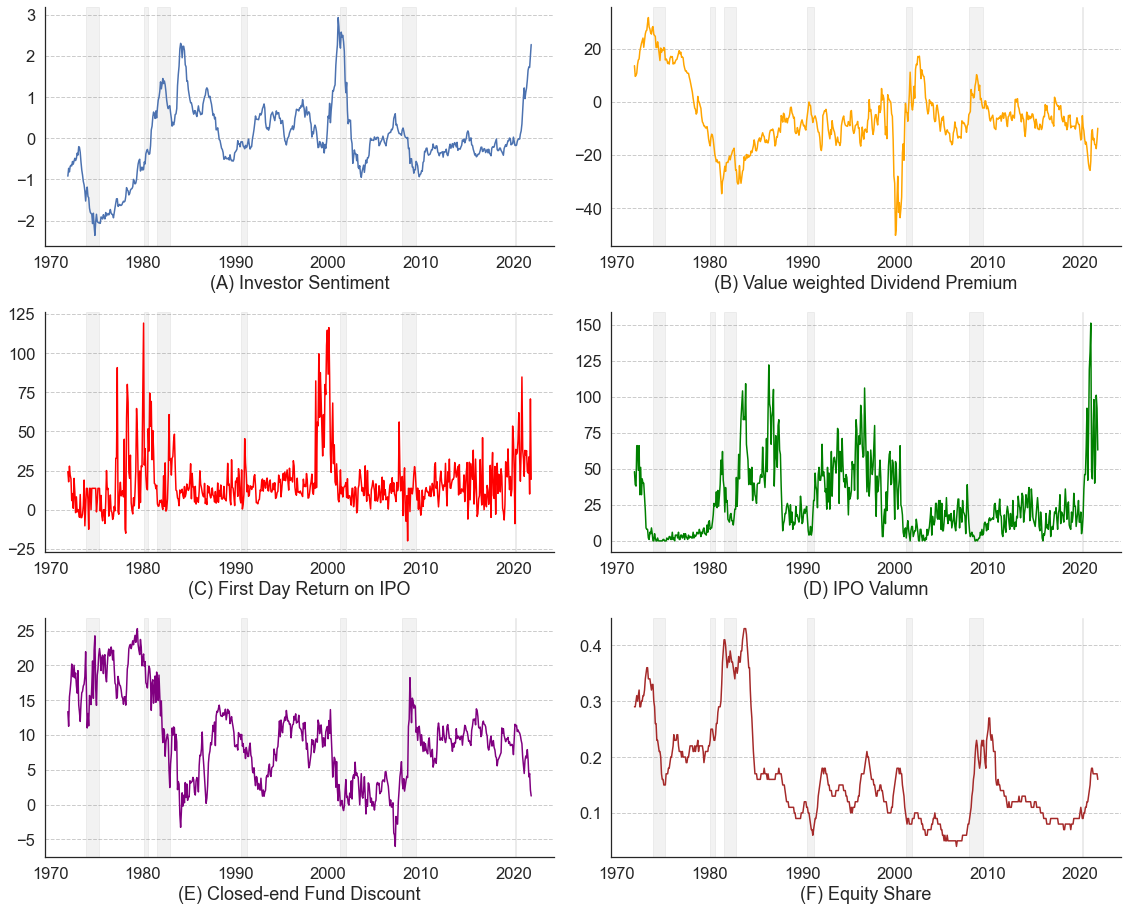

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=1.5, style='white')

fig, ax = plt.subplots(3,2, figsize=(16,13))
sns.lineplot(data=sent, x='year_month', y='SENT', ax=ax[0][0])
sns.lineplot(data=sent, x='year_month', y='pdnd', ax=ax[0][1], color='orange')
sns.lineplot(data=sent, x='year_month', y='ripo', ax=ax[1][0], color='red')
sns.lineplot(data=sent, x='year_month', y='nipo', ax=ax[1][1], color='green')
sns.lineplot(data=sent, x='year_month', y='cefd', ax=ax[2][0], color='purple')
sns.lineplot(data=sent, x='year_month', y='s', ax=ax[2][1], color='brown')

ax[0][0].set(xlabel='(A) Investor Sentiment', ylabel=None)
ax[0][1].set(xlabel='(B) Value weighted Dividend Premium', ylabel=None)
ax[1][0].set(xlabel='(C) First Day Return on IPO', ylabel=None)
ax[1][1].set(xlabel='(D) IPO Valumn', ylabel=None)
ax[2][0].set(xlabel='(E) Closed-end Fund Discount', ylabel=None)
ax[2][1].set(xlabel='(F) Equity Share', ylabel=None)

# shade recession area
for i in range(1, 8):
 ax[0][0].axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.1, color='grey')
 ax[0][1].axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.1, color='grey')
 ax[1][0].axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.1, color='grey')
 ax[1][1].axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.1, color='grey')
 ax[2][0].axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.1, color='grey')
 ax[2][1].axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.1, color='grey')

 
for a in range(0,3):
  for b in range(0,2):
    ax[a][b].grid(axis='y', linestyle='--')

# remove frame
sns.despine(fig)

# outpot plot
plt.tight_layout()  # Adjust subplot layout for better spacing

# Specify high resolution (dpi) when saving the figure using Matplotlib's savefig
plt.savefig('graphics/sentiment.png', dpi=300)

## Plot financial market data

In [38]:
sp500['year_month'] = pd.to_datetime(sp500['year_month'].astype(str), format='%Y-%m')

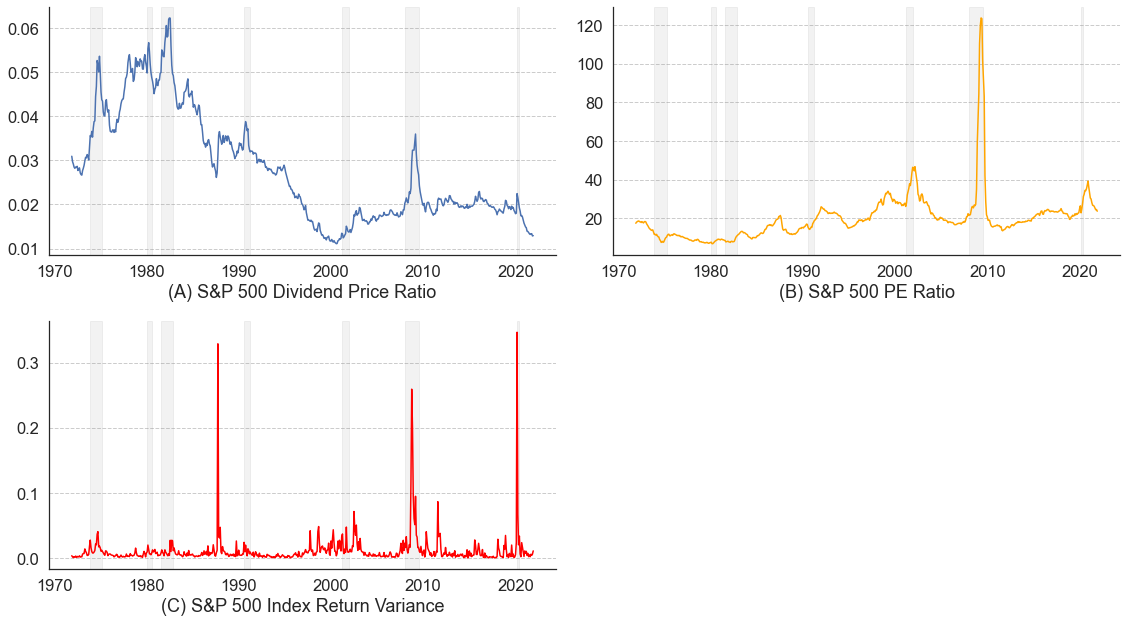

In [39]:
sns.set_theme(font_scale=1.5, style='white')

fig, ax = plt.subplots(2,2, figsize=(16,9))

sns.lineplot(data=sp500, x='year_month', y='sp500_divprc', ax=ax[0][0])
sns.lineplot(data=sp500, x='year_month', y='sp500_pe', ax=ax[0][1], color='orange')
sns.lineplot(data=sp500, x='year_month', y='sp500var', ax=ax[1][0], color='red')

ax[0][0].set(xlabel='(A) S&P 500 Dividend Price Ratio', ylabel=None)
ax[0][1].set(xlabel='(B) S&P 500 PE Ratio', ylabel=None)
ax[1][0].set(xlabel='(C) S&P 500 Index Return Variance', ylabel=None)
ax[1][1].axis("off")

# shade recession area
for i in range(1, 8):
 ax[0][0].axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.1, color='grey')
 ax[0][1].axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.1, color='grey')
 ax[1][0].axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.1, color='grey')
 
for a in range(0,2):
  for b in range(0,2):
    ax[a][b].grid(axis='y', linestyle='--')

# remove frame
sns.despine(fig)

# outpot plot
plt.tight_layout()  # Adjust subplot layout for better spacing

# Specify high resolution (dpi) when saving the figure using Matplotlib's savefig
plt.savefig('graphics/financial_market.png', dpi=300)

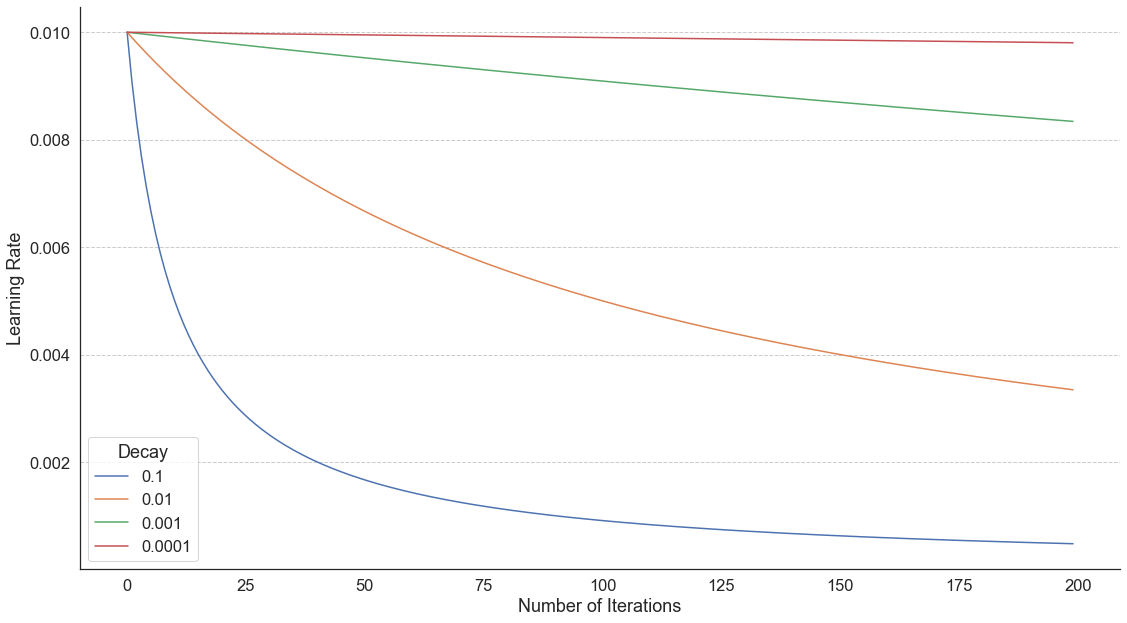

In [25]:
# demonstrate the effect of decay on the learning rate

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set_theme(font_scale=1.5, style='white')

# learning rate decay
def decay_lrate(initial_lrate, decay, iteration):
  return initial_lrate * (1.0 / (1.0 + decay * iteration))

decays = [1E-1, 1E-2, 1E-3, 1E-4]
lrate = 0.01
n_updates = 200

fig, axes = plt.subplots(1,1,figsize=(16,9))

for decay in decays:
# calculate learning rates for updates
  lrates = [decay_lrate(lrate, decay, i) for i in range(n_updates)]
# plot result
  sns.lineplot(lrates, label=str(decay))

plt.xlabel('Number of Iterations')
plt.ylabel('Learning Rate')
plt.grid(axis='y', linestyle='--')
plt.legend(title='Decay')
sns.despine(fig)

# outpot plot
plt.tight_layout()  # Adjust subplot layout for better spacing

# Specify high resolution (dpi) when saving the figure using Matplotlib's savefig
plt.savefig('graphics/lr_schedule.png', dpi=300)